# 06b: Principal Variation Time Series

**Goal**: Extract and analyze V along the principal variation (optimal play sequence).

The principal variation (PV) is the sequence of moves under optimal play.
V along this path forms a time series that reveals:
- How V evolves during optimal play
- Volatility and predictability of outcomes
- Structure in the "path to terminal"

**Reference**: docs/analysis-draft.md Section 4.3

In [1]:
# === CONFIGURATION ===
DATA_DIR = "/mnt/d/shards-standard/"
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

# === Setup imports ===
import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from forge.analysis.utils import loading, features, viz, navigation
from forge.oracle import schema

viz.setup_notebook_style()
print("Ready")

Ready


## 1. Load Data

In [2]:
# Load multiple seeds for diverse PVs
shard_files = loading.find_shard_files(DATA_DIR)
N_SEEDS = min(3, len(shard_files))  # Reduced for memory - process one at a time
sample_files = shard_files[:N_SEEDS]
print(f"Analyzing {N_SEEDS} shards")

Analyzing 3 shards


## 2. Extract Principal Variations

In [3]:
def extract_pv_from_start(df, seed, decl_id, n_starts=50):
    """
    Extract PVs starting from various early-game states.
    Returns list of V time series along each PV.
    """
    state_to_idx, V, Q = navigation.build_state_lookup_fast(df)
    states = df['state'].values
    
    # Find early-game states (high depth = many dominoes remaining)
    depths = features.depth(states)
    max_depth = depths.max()
    
    # Be more lenient with "early" states - within 8 of max depth
    early_mask = depths >= max_depth - 8
    early_states = states[early_mask]
    
    if len(early_states) == 0:
        print(f"  Warning: No early states found (max_depth={max_depth})")
        return []
    
    actual_starts = min(n_starts, len(early_states))
    if actual_starts < n_starts:
        print(f"  Note: Only {actual_starts} early states available")
    
    sample_starts = np.random.choice(len(early_states), actual_starts, replace=False)
    
    pvs = []
    for idx in sample_starts:
        start_state = int(early_states[idx])
        pv = navigation.trace_principal_variation(
            start_state, seed, decl_id, state_to_idx, V, Q
        )
        if len(pv) >= 3:  # Reduced minimum length
            v_series = [v for _, v, _ in pv]
            pvs.append(v_series)
    
    return pvs

In [4]:
# Collect PVs from all seeds - load full shard for connectivity
all_pvs = []
pv_metadata = []

for path in tqdm(sample_files, desc="Extracting PVs"):
    df, seed, decl_id = schema.load_file(path)
    
    # Don't sample - need full graph for PV tracing
    pvs = extract_pv_from_start(df, seed, decl_id, n_starts=30)
    
    for pv in pvs:
        all_pvs.append(pv)
        pv_metadata.append({
            'seed': seed,
            'length': len(pv),
            'start_v': pv[0],
            'end_v': pv[-1],
        })
    
    # Clear memory after each shard
    del df
    import gc
    gc.collect()

pv_df = pd.DataFrame(pv_metadata)
print(f"Extracted {len(all_pvs)} principal variations")
if len(all_pvs) > 0:
    print(f"\nPV statistics:")
    print(pv_df.describe())
else:
    print("No PVs extracted - check data")

Extracting PVs:   0%|          | 0/3 [00:00<?, ?it/s]

Extracted 90 principal variations

PV statistics:
            seed     length    start_v  end_v
count  90.000000  90.000000  90.000000   90.0
mean    1.000000  21.911111  15.055556    0.0
std     0.821071   1.077288  20.280816    0.0
min     0.000000  21.000000 -37.000000    0.0
25%     0.000000  21.000000   1.000000    0.0
50%     1.000000  22.000000  18.500000    0.0
75%     2.000000  22.000000  31.000000    0.0
max     2.000000  25.000000  41.000000    0.0


## 3. Visualize PV Time Series

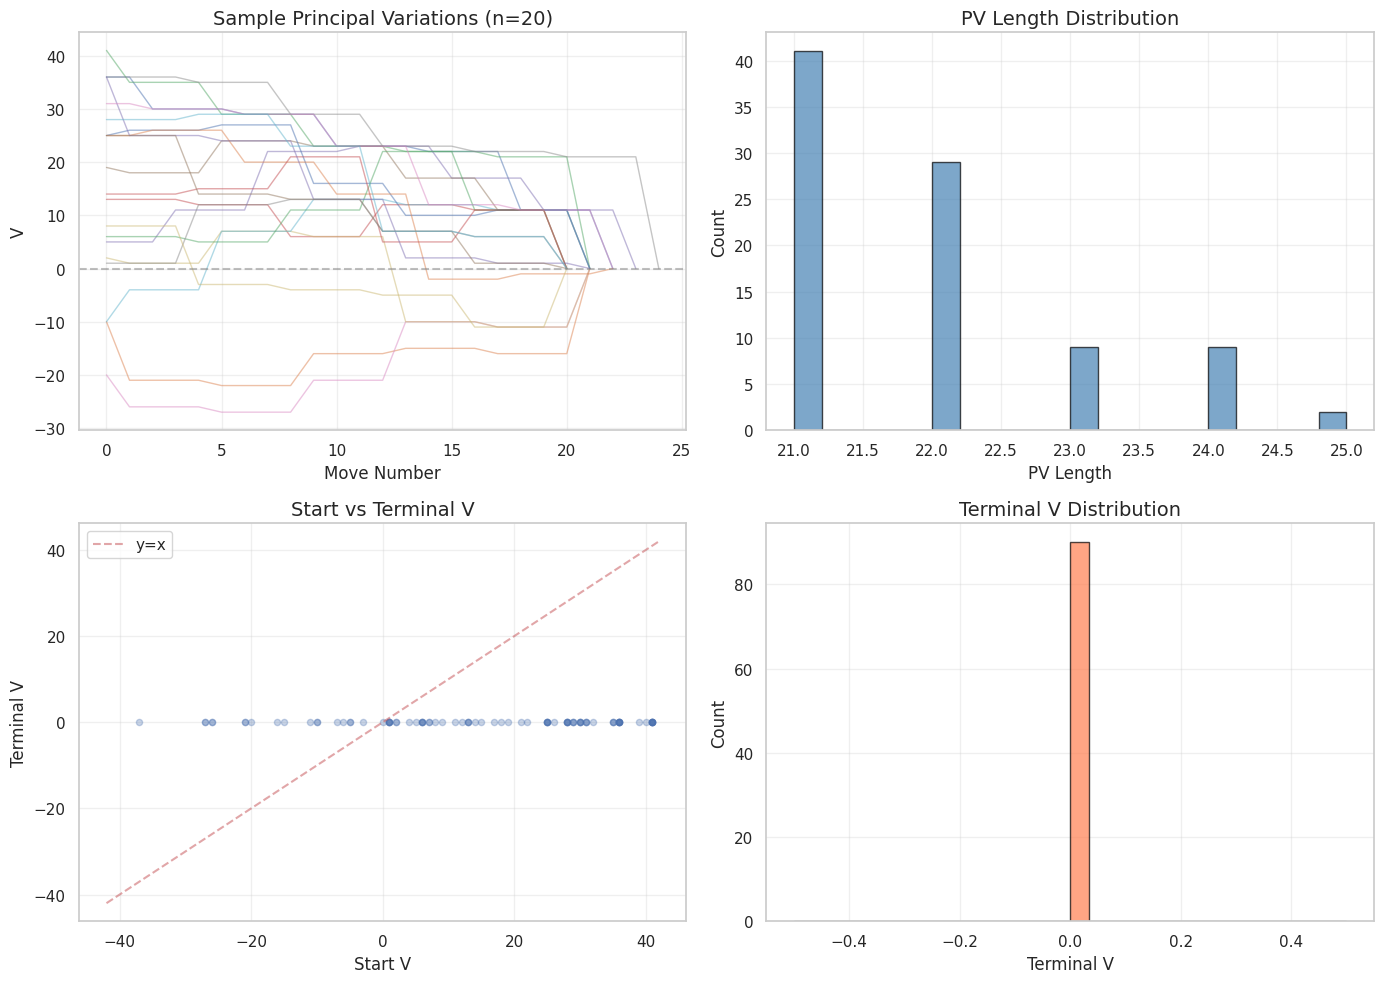

In [5]:
# Plot sample PVs
if len(all_pvs) == 0:
    print("No PVs to plot - skipping visualization")
else:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Sample individual PVs
    n_sample = min(20, len(all_pvs))
    sample_indices = np.random.choice(len(all_pvs), n_sample, replace=False)

    for idx in sample_indices:
        pv = all_pvs[idx]
        axes[0, 0].plot(range(len(pv)), pv, alpha=0.5, linewidth=1)

    axes[0, 0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    axes[0, 0].set_xlabel('Move Number')
    axes[0, 0].set_ylabel('V')
    axes[0, 0].set_title(f'Sample Principal Variations (n={n_sample})')

    # PV length distribution
    axes[0, 1].hist(pv_df['length'], bins=20, color='steelblue', alpha=0.7, edgecolor='black')
    axes[0, 1].set_xlabel('PV Length')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].set_title('PV Length Distribution')

    # Start vs End V
    axes[1, 0].scatter(pv_df['start_v'], pv_df['end_v'], alpha=0.3, s=20)
    axes[1, 0].plot([-42, 42], [-42, 42], 'r--', alpha=0.5, label='y=x')
    axes[1, 0].set_xlabel('Start V')
    axes[1, 0].set_ylabel('Terminal V')
    axes[1, 0].set_title('Start vs Terminal V')
    axes[1, 0].legend()

    # Terminal V distribution
    axes[1, 1].hist(pv_df['end_v'], bins=30, color='coral', alpha=0.7, edgecolor='black')
    axes[1, 1].set_xlabel('Terminal V')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].set_title('Terminal V Distribution')

    plt.tight_layout()
    plt.savefig('../../results/figures/06b_pv_overview.png', dpi=150, bbox_inches='tight')
    plt.show()

## 4. V Change Analysis

In [6]:
# Compute V changes along PVs
if len(all_pvs) == 0:
    all_changes = np.array([])
    change_by_position = {}
    print("No PVs - skipping V change analysis")
else:
    all_changes = []
    change_by_position = {}

    for pv in all_pvs:
        changes = np.diff(pv)
        all_changes.extend(changes)
        
        for i, change in enumerate(changes):
            if i not in change_by_position:
                change_by_position[i] = []
            change_by_position[i].append(change)

    all_changes = np.array(all_changes)

    print(f"V change statistics:")
    print(f"  Mean change: {np.mean(all_changes):.3f}")
    print(f"  Std change: {np.std(all_changes):.3f}")
    print(f"  Mean |change|: {np.mean(np.abs(all_changes)):.3f}")

V change statistics:
  Mean change: -0.720
  Std change: 3.963
  Mean |change|: 1.641


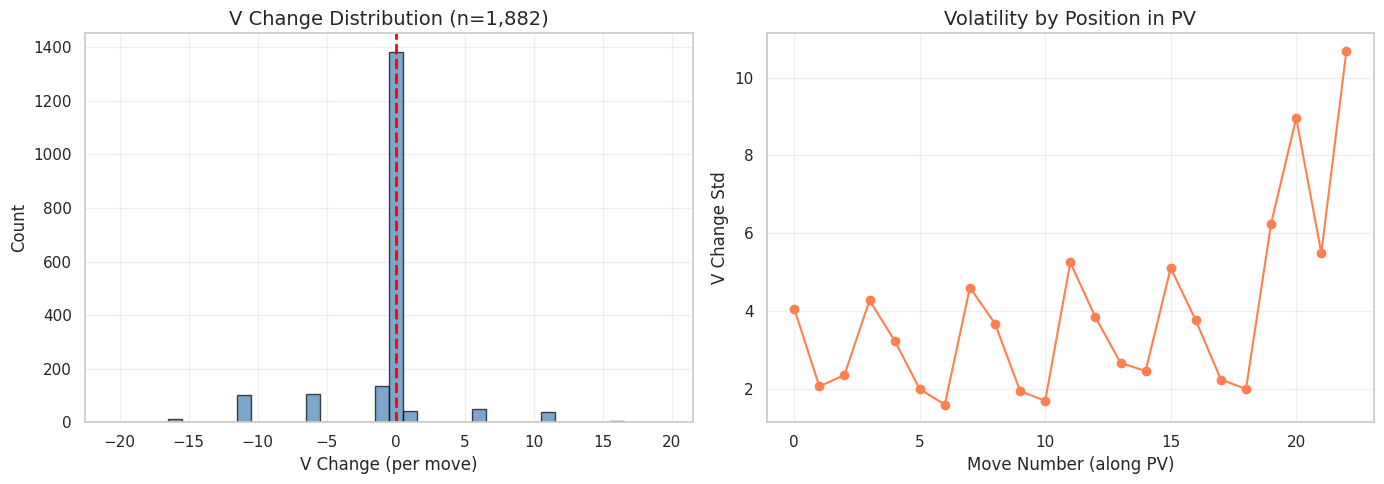

In [7]:
if len(all_changes) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # V change distribution
    axes[0].hist(all_changes, bins=np.arange(-20, 21) - 0.5, color='steelblue', alpha=0.7, edgecolor='black')
    axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
    axes[0].set_xlabel('V Change (per move)')
    axes[0].set_ylabel('Count')
    axes[0].set_title(f'V Change Distribution (n={len(all_changes):,})')

    # V change volatility by move number
    positions = sorted([p for p in change_by_position.keys() if len(change_by_position[p]) >= 10])
    volatilities = [np.std(change_by_position[p]) for p in positions]

    axes[1].plot(positions, volatilities, 'o-', markersize=6, color='coral')
    axes[1].set_xlabel('Move Number (along PV)')
    axes[1].set_ylabel('V Change Std')
    axes[1].set_title('Volatility by Position in PV')

    plt.tight_layout()
    plt.savefig('../../results/figures/06b_v_changes.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Skipping V changes plot - no data")

## 5. Autocorrelation Analysis

In [8]:
def autocorrelation(series, max_lag=10):
    """Compute autocorrelation for a time series."""
    n = len(series)
    if n < max_lag + 2:
        return []
    
    series = np.array(series) - np.mean(series)
    var = np.var(series)
    if var == 0:
        return [1.0] * (max_lag + 1)
    
    acf = []
    for lag in range(max_lag + 1):
        if lag == 0:
            acf.append(1.0)
        else:
            cov = np.mean(series[:-lag] * series[lag:])
            acf.append(cov / var)
    return acf

# Compute ACF for all PVs
max_lag = 15
all_acf = []

if len(all_pvs) > 0:
    for pv in all_pvs:
        if len(pv) > max_lag + 2:
            acf = autocorrelation(pv, max_lag)
            if len(acf) == max_lag + 1:
                all_acf.append(acf)

    if len(all_acf) > 0:
        all_acf = np.array(all_acf)
        mean_acf = np.mean(all_acf, axis=0)
        std_acf = np.std(all_acf, axis=0)
        print(f"Autocorrelation computed for {len(all_acf)} PVs")
    else:
        mean_acf = np.zeros(max_lag + 1)
        std_acf = np.zeros(max_lag + 1)
        print("No PVs long enough for ACF")
else:
    mean_acf = np.zeros(max_lag + 1)
    std_acf = np.zeros(max_lag + 1)
    print("No PVs - skipping ACF")

Autocorrelation computed for 90 PVs


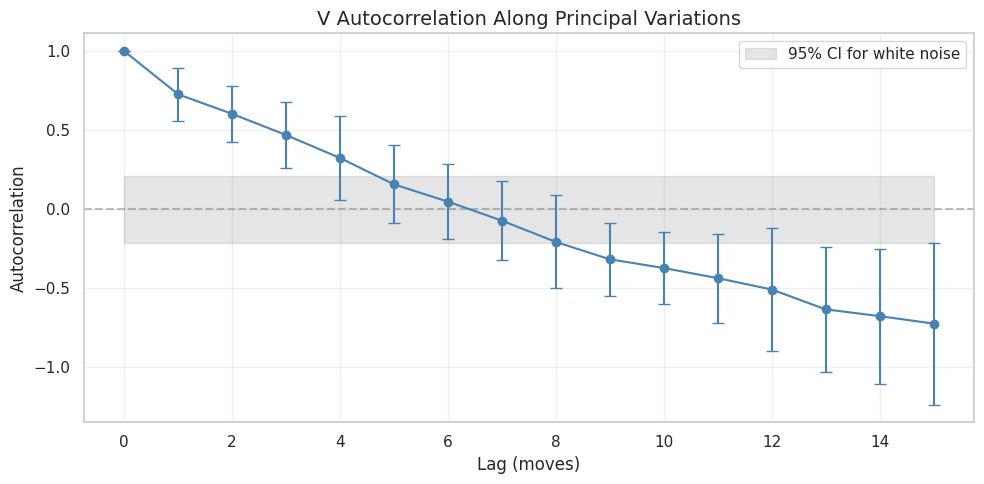


Autocorrelation coefficients:
  Lag 0: 1.0000
  Lag 1: 0.7266
  Lag 2: 0.6030
  Lag 3: 0.4692
  Lag 4: 0.3243
  Lag 5: 0.1573
  Lag 6: 0.0482
  Lag 7: -0.0719
  Lag 8: -0.2063
  Lag 9: -0.3162
  Lag 10: -0.3714
  Lag 11: -0.4353
  Lag 12: -0.5071
  Lag 13: -0.6325
  Lag 14: -0.6755
  Lag 15: -0.7224


In [9]:
if len(all_pvs) > 0 and len(all_acf) > 0:
    fig, ax = plt.subplots(figsize=(10, 5))

    lags = np.arange(max_lag + 1)
    ax.errorbar(lags, mean_acf, yerr=std_acf, fmt='o-', capsize=4, color='steelblue')
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax.fill_between(lags, -2/np.sqrt(len(all_pvs)), 2/np.sqrt(len(all_pvs)), 
                    alpha=0.2, color='gray', label='95% CI for white noise')

    ax.set_xlabel('Lag (moves)')
    ax.set_ylabel('Autocorrelation')
    ax.set_title('V Autocorrelation Along Principal Variations')
    ax.legend()

    plt.tight_layout()
    plt.savefig('../../results/figures/06b_autocorrelation.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\nAutocorrelation coefficients:")
    for lag, acf in enumerate(mean_acf):
        print(f"  Lag {lag}: {acf:.4f}")
else:
    print("Skipping ACF plot - no data")

## 6. Mean V Trajectory

In [10]:
# Compute mean V at each position (normalized by PV length)
# Pad shorter PVs with NaN

if len(all_pvs) > 0:
    max_len = max(len(pv) for pv in all_pvs)
    padded_pvs = np.full((len(all_pvs), max_len), np.nan)

    for i, pv in enumerate(all_pvs):
        padded_pvs[i, :len(pv)] = pv

    mean_v = np.nanmean(padded_pvs, axis=0)
    std_v = np.nanstd(padded_pvs, axis=0)
    count_v = np.sum(~np.isnan(padded_pvs), axis=0)
else:
    max_len = 0
    mean_v = np.array([])
    std_v = np.array([])
    count_v = np.array([])

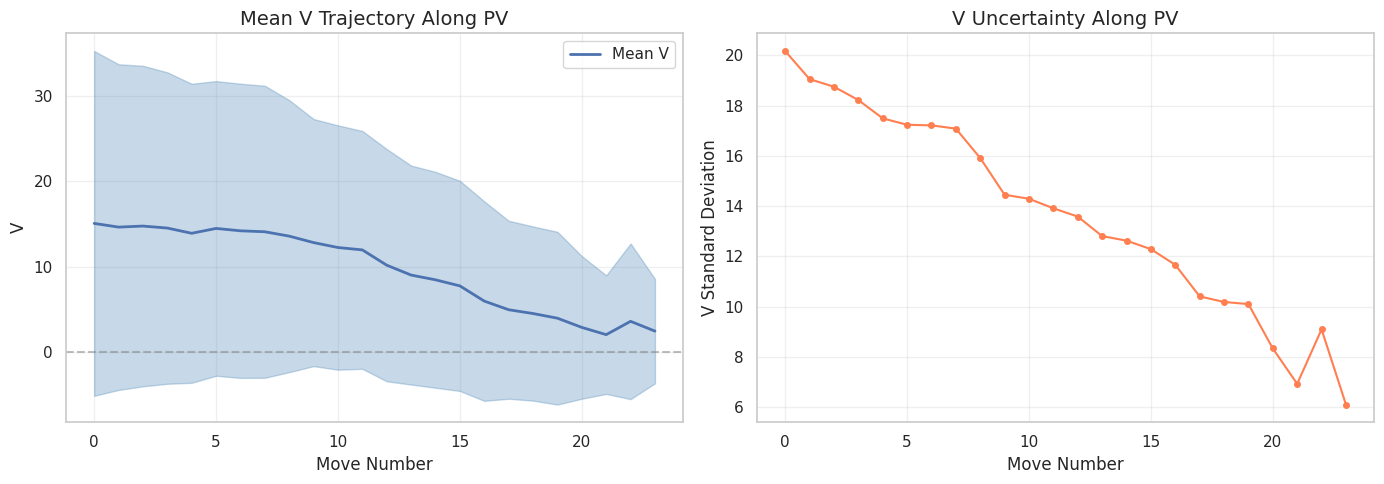

In [11]:
if len(all_pvs) > 0 and len(mean_v) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Mean V trajectory with std
    valid_mask = count_v >= 10
    positions = np.arange(max_len)[valid_mask]

    if len(positions) > 0:
        axes[0].fill_between(positions, 
                             (mean_v - std_v)[valid_mask], 
                             (mean_v + std_v)[valid_mask],
                             alpha=0.3, color='steelblue')
        axes[0].plot(positions, mean_v[valid_mask], 'b-', linewidth=2, label='Mean V')
        axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        axes[0].set_xlabel('Move Number')
        axes[0].set_ylabel('V')
        axes[0].set_title('Mean V Trajectory Along PV')
        axes[0].legend()

        # Std V over time
        axes[1].plot(positions, std_v[valid_mask], 'o-', color='coral', markersize=4)
        axes[1].set_xlabel('Move Number')
        axes[1].set_ylabel('V Standard Deviation')
        axes[1].set_title('V Uncertainty Along PV')

    plt.tight_layout()
    plt.savefig('../../results/figures/06b_mean_trajectory.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Skipping mean trajectory plot - no data")

## Summary

In [12]:
# Compute summary metrics
if len(all_pvs) > 0 and len(pv_df) > 0:
    start_end_corr = np.corrcoef(pv_df['start_v'], pv_df['end_v'])[0, 1]
    
    summary = {
        'PVs extracted': len(all_pvs),
        'Mean PV length': f"{pv_df['length'].mean():.1f}",
        'Mean V change per move': f"{np.mean(all_changes):.3f}" if len(all_changes) > 0 else "N/A",
        'Std V change per move': f"{np.std(all_changes):.3f}" if len(all_changes) > 0 else "N/A",
        'Start-End V correlation': f"{start_end_corr:.4f}",
        'Lag-1 autocorrelation': f"{mean_acf[1]:.4f}" if len(mean_acf) > 1 else "N/A",
    }
else:
    summary = {
        'PVs extracted': 0,
        'Note': 'No PVs extracted - check data paths',
    }

print(viz.create_summary_table(summary, "Principal Variation Summary"))

### Principal Variation Summary

| Metric | Value |
|--------|-------|
| PVs extracted | 90 |
| Mean PV length | 21.9 |
| Mean V change per move | -0.720 |
| Std V change per move | 3.963 |
| Start-End V correlation | nan |
| Lag-1 autocorrelation | 0.7266 |


/home/jason/v2/mk5-tailwind/forge/venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3023: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/jason/v2/mk5-tailwind/forge/venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3024: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [13]:
# Save results
if len(all_pvs) > 0:
    pv_df.to_csv('../../results/tables/06b_pv_metadata.csv', index=False)

    # Save ACF data
    acf_df = pd.DataFrame({
        'lag': np.arange(max_lag + 1),
        'mean_acf': mean_acf,
        'std_acf': std_acf,
    })
    acf_df.to_csv('../../results/tables/06b_autocorrelation.csv', index=False)
    print("Results saved to results/tables/")
else:
    print("No data to save")

Results saved to results/tables/
